In [1]:
from __future__ import print_function
import sys,os,datetime
import cv2 as cv
import cv2 as cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
import csv

In [2]:
print('openCV',cv.__version__)
print('numpy',np.__version__)

openCV 3.2.0
numpy 1.13.3


In [3]:
dirTrain1 = '../Data/train/train/level-1'
dirTrain2 = '../Data/train/train/level-2'
dirTrain3 = '../Data/train/train/level-3'
dirTrain  = dirTrain2
dirDev    = '../Data/dev/dev'
dirForSave = '../Work'

In [4]:
shape2D = (416,416)

In [5]:
def NNTrain(dirTrain) :
    listTrain= os.listdir(dirTrain); len(listTrain); listTrain[:12]
    listTrainNN = []
    for ff in listTrain :
        if ff.lower().endswith('.txt') : listTrainNN.append(ff.split('_')[0])
    return(listTrainNN)
listTrainNN = NNTrain(dirTrain)
len(listTrainNN), listTrainNN[:15]

(1495,
 ['1003',
  '1009',
  '100',
  '1012',
  '1018',
  '1021',
  '984',
  '994',
  '995',
  '997',
  '9',
  '952',
  '955',
  '956',
  '959'])

In [6]:
def diffPicts (img1, img2) :
    diff = []
    for cc in range(img1.shape[2]) :
        ccc   = np.abs(img1[:,:,cc]-img2[:,:,cc])
        cccL2 = np.sqrt(np.square(ccc).mean())
        cccL1 = ccc.max()
        diff.append([cccL1,cccL2,ccc])
    diffL2 = np.zeros(ccc.shape)
    for L1,L2,ccc in diff : diffL2 += np.square(ccc)
    diffL2 = np.sqrt(diffL2)
    return(diff,diffL2)

def minDeltaRC (img1,img2, ranging=range(-5,6), printOK=False) :
    r0,c0 = (img2.shape[0]-img1.shape[0])/2, (img2.shape[1]-img1.shape[1])/2
    minL2 = [390*390*250.0,0,0]
    for dr in ranging :
        for dc in ranging :
            imgX2 = img2[r0+dr:r0+img1.shape[0]+dr,c0+dc:c0+img1.shape[1]+dc,:]
            diff, L2 = diffPicts(img1,imgX2)
            if (minL2[0]>L2.mean()) : minL2 = (L2.mean(),dr,dc,r0+dr,c0+dc)
            if printOK : print (dr,dc,'\t',minL2[0],'\t',L2.max(),L2.mean(),L2.std(),np.median(L2))
    return(minL2)

#print('min=',minDeltaRC(img1,img2))

In [7]:
def pictNorm (img255, std=False) :
    imgF32 = np.float32(img255) 
    for cc in range(img255.shape[2]) :
        imgF32[:,:,cc] -= imgF32[:,:,cc].mean()
        if std : imgF32[:,:,cc] /= imgF32[:,:,cc].std()**2
        imgF32[:,:,cc] /= 127.0
    return(imgF32)

In [8]:
def computeORB (img, debug=False) :
    orb    = cv2.ORB_create();
    kp     = orb.detect(img,None)
    kp,des = orb.compute(img,kp)
    if debug :
        print (len(kp))
        print (len(des),len(des[0]),"\n",des[0],"\n",des[1])
    return kp,des

def computeMatches (des1,des2) :
    if True :
        bf      = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
        matches = bf.match(des1,des2);
        #????matches = bf.knnMatch(des1,des2,k=1);
    if False :
        index_params = dict(algorithm = 6, #cv2.FLANN_INDEX_LSH,
                            table_number = 6, 
                            key_size = 12,    
                            multi_probe_level = 1)
        search_params = dict(checks=100)
        flann   = cv2.FlannBasedMatcher(index_params,search_params)
        matchesI = flann.knnMatch(des1,des2,k=3);
        matches  = [];
        for mI in matchesI :
            for m in mI : matches.append(m);
    return matches    

def drawMatches(img1,kp1,des1,img2,kp2,des2, show=False, showNN=20):
    matches = computeMatches(des1,des2);
    matches = sorted(matches,key=lambda x:x.distance)
    if  show :
        imgM    = img1.copy()
        #imgM    = cv2.drawMatches(img1,kp1,img2,kp2,matches[:20],imgM,flags=4)
        imgM    = cv2.drawMatches(img1,kp1,img2,kp2,matches[:showNN],imgM,flags=2) #4)
        #imgM    = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,imgM,flags=2) #4)
        
        plt.figure(figsize=(15,15)); plt.imshow(imgM), plt.show()
    return(matches)


In [9]:
len(listTrainNN)

1495

In [80]:
print(datetime.datetime.now())

for ii,dirTrain in enumerate((dirTrain1,dirTrain2,dirTrain3)) :
    
    #if ii==1 : break
    
    listTrainNN = NNTrain(dirTrain)

    X1 = np.zeros((len(listTrainNN),)+shape2D+(3,),dtype=np.float32)
    X2 = np.zeros((len(listTrainNN),)+shape2D+(3,),dtype=np.float32)
    YY = np.zeros((len(listTrainNN),)+shape2D+(1,),dtype=np.float32)
    print(datetime.datetime.now(),X1.shape, X2.shape,YY.shape,dirTrain)
    
    for NN in range(len(listTrainNN)) :
        img1 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'.tif'),-1)
        img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)
        img3 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_mask.tif'),-1); img3 = img3.reshape(img3.shape+(1,))



        if 1 :
            img1 = cv2.GaussianBlur(img1,(3,3),0)
            img2 = cv2.GaussianBlur(img2,(3,3),0)

        if 0 :
            img1 = cv2.boxFilter(img1,-1,(5,5))
            img2 = cv2.boxFilter(img2,-1,(5,5))


        if 1 :
            img1  = pictNorm(img1)
            img2  = pictNorm(img2)

        rcL2,_,_,r0,c0 = minDeltaRC(img1,img2,ranging=range(-10,10))
        img2X = img2[r0:r0+img1.shape[0],c0:c0+img1.shape[1]]

        if NN%100==0 : print(datetime.datetime.now(),NN,rcL2,r0,c0)

        if 0 :
            img1 = cv2.GaussianBlur(img1,(3,3),0)
            img2X = cv2.GaussianBlur(img2X,(3,3),0)

        if 1 :
            img1  = cv2.boxFilter(img1, -1,(5,5))
            img2X = cv2.boxFilter(img2X,-1,(5,5))

        X1[NN,13:13+390,13:13+390,:], X2[NN,13:13+390,13:13+390,:], YY[NN,13:13+390,13:13+390,:] = img1, img2X, img3


    if 1 :
        np.save(os.path.join(dirForSave,'X1-'+str(ii)+'.npy'),X1)
        np.save(os.path.join(dirForSave,'X2-'+str(ii)+'.npy'),X2)
        np.save(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'),YY)
        print(datetime.datetime.now(),'Save:',X1.shape, X2.shape,YY.shape,dirTrain)
        
print(datetime.datetime.now())

2018-02-12 08:26:44.394974
2018-02-12 08:26:44.399563 (751, 416, 416, 3) (751, 416, 416, 3) (751, 416, 416, 1) ../Data/train/train/level-1
2018-02-12 08:26:45.352151 0 0.0658074848063 55 56
2018-02-12 08:28:17.167419 100 0.0567938326306 56 56
2018-02-12 08:29:41.904455 200 0.0676420703097 56 53
2018-02-12 08:31:06.054255 300 0.0566413581779 54 50
2018-02-12 08:32:30.244880 400 0.0549176484386 46 64
2018-02-12 08:33:54.280129 500 0.0510736484509 54 56
2018-02-12 08:35:18.188724 600 0.0628774579128 55 55
2018-02-12 08:36:42.517704 700 0.205298348405 55 52
2018-02-12 08:37:41.104001 Save: (751, 416, 416, 3) (751, 416, 416, 3) (751, 416, 416, 1) ../Data/train/train/level-1
2018-02-12 08:37:41.244491 (1495, 416, 416, 3) (1495, 416, 416, 3) (1495, 416, 416, 1) ../Data/train/train/level-2
2018-02-12 08:37:42.200435 0 0.135193295812 55 55
2018-02-12 08:39:49.218562 100 0.110332033177 55 55
2018-02-12 08:41:22.393742 200 0.0446885574285 55 55
2018-02-12 08:42:52.506891 300 0.061369903808 55 54


In [10]:
if 0 :
    np.save(os.path.join(dirForSave,'X1.npy'),X1)
    np.save(os.path.join(dirForSave,'X2.npy'),X2)
    np.save(os.path.join(dirForSave,'YY.npy'),YY)
    
if 0 :
    ii = 0
    X1 = np.load(os.path.join(dirForSave,'X1-'+str(ii)+'.npy'))
    X2 = np.load(os.path.join(dirForSave,'X2-'+str(ii)+'.npy'))
    YY = np.load(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'))
    print(datetime.datetime.now(),'Load: ',ii,X1.shape, X2.shape,YY.shape)
    
if 1 :
    print(datetime.datetime.now(),'For:  ')
    iil = []
    for ii in (0,1,2) :
        YY = np.load(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'))
        iil.append(len(YY))
    iis = int(np.array(iil).sum())
    
    X1 = np.zeros((iis,)+shape2D+(3,),dtype=np.float32)
    X2 = np.zeros((iis,)+shape2D+(3,),dtype=np.float32)
    YY = np.zeros((iis,)+shape2D+(1,),dtype=np.float32)
    
    iis = 0
    
    for ii in (0,1,2) :
        
        T1  = np.load(os.path.join(dirForSave,'X1-'+str(ii)+'.npy'))
        T2  = np.load(os.path.join(dirForSave,'X2-'+str(ii)+'.npy'))
        TT  = np.load(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'))
        
        X1[iis:iis+len(TT)], X2[iis:iis+len(TT)], YY[iis:iis+len(TT)] = T1, T2, TT
        
        iis+= len(TT)
        
        del TT,T1, T2
        
    print(datetime.datetime.now(),'Load: ', X1.shape, X2.shape, YY.shape)
    

2018-02-15 21:14:22.116866 For:  
2018-02-15 21:17:27.773623 Load:  (4119, 416, 416, 3) (4119, 416, 416, 3) (4119, 416, 416, 1)


In [11]:
YY = YY/YY.max()
YY.max()

1.0

In [13]:
X1.shape,X2.shape,YY.shape

((4119, 416, 416, 3), (4119, 416, 416, 3), (4119, 416, 416, 1))

In [14]:
from keras.models import Input, Model
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Concatenate, Activation, Dropout,Add
from keras.layers import Conv2DTranspose, SpatialDropout2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import keras
import keras.backend as K 

Using TensorFlow backend.


In [15]:
sys.path.append('../Python')
from LinkNetBoba import LinkNetBoba

In [16]:
#!/usr/local/bin/python
# -*- coding: utf-8 -*-
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# model LinkNet realization for Keras (TensorFlow?)
#
# from: https://arxiv.org/pdf/1707.03718.pdf
# 
#   Abhishek Chaurasia, Eugenio Culurciello
#   LinkNet: Exploiting Encoder Representations for Efficient Semantic Segmentation
#
#
#
# realizate by Vladimir Sorokin
#
# For FREE use
#
#
# keys: LinkNet, Keras, Boba
#
# 2017-11-25
#
# 2017-12-11 1. The add operator in blockEncoder move after batch operator and after activation operator
#            2. Add batch operator 2th conv2 in blockEncoder   
#
# 2017-12-15 1. Fix bugs with names layers
#            2. Change last layers
#            3. Add activation parameter for last layer
#            4. Add conv2D before last layer
#
# 2018-02-11
#            1. Fix bugs (acti_last --> acti in pre-last activation)
#            2. Add prefix-name parameter
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from keras.models import Input, Model
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Concatenate, Activation, Dropout,Add
from keras.layers import Conv2DTranspose, SpatialDropout2D
from keras.layers.normalization import BatchNormalization

def LinkNetBoba (img_shape, n_out=1, depth=4, 
                 acti='elu', acti_last='sigmoid', 
                 dropout=False, batch=True, 
                 prefix='boba',printOK=False):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Encoder block
    #
    
    def blockEncoder(i, depth, maxDepth, mm, nn) :
        
        io = i
        
        #print('e 0 depth=',depth,io.shape)
        
        io = Conv2D(nn, (3, 3), strides=2, padding='same', name=prefix+"_"+'conv1d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath1d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)
        
        #print('e 1 depth=',depth,io.shape)
        
        io = Conv2D(nn, (3, 3), padding='same', name=prefix+"_"+'conv2d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath2d'+str(maxDepth-depth))(io)
        
        ii = Conv2D(nn, (1, 1), strides=2, name=prefix+"_"+'ii1d'+str(maxDepth-depth))(i)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath3d'+str(maxDepth-depth))(io) # 2017-12-11 add batch
        
        io = Add()([io, ii]); io1 = io;
        
        io = Activation(acti)(io)   # 2017-12-11 change point add before activation after batch
        
        io = Conv2D(nn, (3, 3), padding='same', name=prefix+"_"+'conv3d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath4d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)                
        
        io = Conv2D(nn, (3, 3), padding='same', name=prefix+"_"+'conv4d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath5d'+str(maxDepth-depth))(io)
        
        io = Add()([io, io1]);     # 2017-12-11 change point add before activation after batch
        
        io = Activation(acti)(io)                
        
        ##io = Concatenate()([io, io1]);
        
        return (io)
        

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Decoder block
    #
    
    def blockDecoder(i, depth, maxDepth, mm, nn) :
        
        io = i
        
        io = Conv2D(mm//4, (1, 1), padding='same', name=prefix+"_"+'convd1d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bathd1d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)                
        
        io = Conv2DTranspose(mm//4, (3, 3), padding='same', name=prefix+"_"+'convd2d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bathd2d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)    
        
        io = UpSampling2D((2,2))(io)
        
        io = Conv2D(nn, (1, 1), padding='same', name=prefix+"_"+'convd3d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bathd3d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)                
        
        return (io)
        

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Level block (recursive call build levels) 
    #
    
    def blockLevel(i, depth, maxDepth):

        #if batch : m = BatchNormalization(name='bath1d'+str(maxDepth-depth))(m)
        #if batch and depth==maxDepth : m = BatchNormalization(name='bath1d'+str(maxDepth-depth))(m)
        
        if depth == maxDepth : return(i);
        
        emm, enn =  emm0[depth-1],  enn0[depth-1]
        dmm, dnn =  dmm0[depth-1],  dnn0[depth-1]
        
        #print('l 0 depth=',depth,i.shape)
        en  = blockEncoder(i,depth,maxDepth,emm,enn)
        
        #print('l 1 depth=',depth,en.shape)
        le  = blockLevel(en,depth+1,maxDepth)
        
        
        
        if printOK : print('l 2 depth={} en={} le={}'.format(depth,en.shape,le.shape))
        io  = Add()([en, le]);
        #io  = Concatenate()([en, le]);
        de  = blockDecoder(io,depth,maxDepth,dmm,dnn)
        #print('l L depth=',depth,en.shape)
        
        return de
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Main function block
    #
    
    maxDepth = 4
    depth    = 0
    
    emm0 = [64, 64,128,256]
    enn0 = [64,128,256,512]
    
    ##emm0 = [64, 64,128,256,512]
    ##enn0 = [64,128,256,512,1024]
    
    dmm0 = enn0
    dnn0 = emm0
    
    i = Input(shape=img_shape, name=prefix+"_"+'input'); io = i
    if True : # always exists  
        io = BatchNormalization(name=prefix+"_"+'bath0d'+str(maxDepth-depth))(io)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Initial function block
    #
    
    #print(io.shape)

    io = Conv2D(64, (7, 7), strides=2, padding='same', name=prefix+"_"+'conv1d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath1d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                
        
    io = MaxPooling2D((3, 3), strides=2, name=prefix+"_"+'pool1d'+str(maxDepth-depth))(io)
    
    ##print('before',io.shape)
    
    # levels block
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Main build levels
    #
    
    io = blockLevel(io,depth+1,maxDepth)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Final function block
    #

    io = Conv2DTranspose(32, (3, 3), padding='same', name=prefix+"_"+'conv2d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath2d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                
    
    io = UpSampling2D((2,2))(io)
        
    io = Conv2D(32, (3,3), padding='same', name=prefix+"_"+'conv3d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath3d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                
    
    if dropout : io = SpatialDropout2D(rate=dropout, name=prefix+"_"+'dropLd'+str(maxDepth-depth))(io)
        
    ###io = UpSampling2D((2,2))(io) -- ?????? do bad output result 
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # The End. Build output
    #
    
    io = Conv2DTranspose(n_out, (2, 2), strides=2, padding='same', name=prefix+"_"+'conv4d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath4d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                

    io = Conv2D(n_out, (3,3), padding='same', name=prefix+"_"+'conv5d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath5d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)

    io = Conv2D(n_out, (1,1), padding='same', name=prefix+"_"+'convLd'+str(maxDepth-depth))(io)
    o = Activation(acti_last)(io)

    return Model(inputs=i, outputs=o, name='LinkNetBoba')

if 0 :

    model10 = LinkNetBoba((512,512,3), n_out=1, dropout=0.20, batch=False, acti='elu')
    model10.summary()


In [17]:
def mergeXX (img_shape,n_out=1, acti='elu', dropout=False, batch=True, acti_last='sigmoid') :
    xx1 = LinkNetBoba(img_shape,prefix='boba1',n_out=3,acti_last='tanh')
    xx2 = LinkNetBoba(img_shape,prefix='boba2',n_out=3,acti_last='tanh')

    io = keras.layers.Add()([xx1.output, xx2.output])

    io = Conv2D(8, (3,3), padding='same')(io)
    if batch : io = BatchNormalization()(io)
    io = Activation(acti)(io)

    io = Conv2D(16, (3,3), padding='same')(io)
    if batch : io = BatchNormalization()(io)
    io = Activation(acti)(io)

    io = Conv2D(n_out, (1,1), padding='same')(io)
    o = Activation(acti_last)(io)

    return Model(inputs=[xx1.input,xx2.input], outputs=o, name='LinkNet2Boba')


In [18]:
#K.clear_session()
import tensorflow as tf

#--------------------------------------------------------------------------
def F1ScoreCC (truth, pred_, th=None, printOK=False) : # classic realization
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
        if printOK : print('not None',th)
        
    tp     = K.sum(truth*pred,           axis=(1,2,3))
    fp     = K.sum(K.abs(truth-1.0)*pred,axis=(1,2,3))
    fn     = K.sum(truth*K.abs(pred-1.0),axis=(1,2,3))
    tn     = K.sum(K.abs(truth-1.0)*K.abs(pred-1.0),axis=(1,2,3))
    
    #if (tp+fp)>0.0 :precision = tp/(tp+fp)
    #if (fp+fn)>0.0 : recall    = tp/(fp+fn)
    
    tpfp   = tp+fp
    tpfn   = tp+fn

    kUp       = tf.to_float(K.not_equal(0.0,tpfp))
    kDown     = tf.to_float(K.equal    (0.0,tpfp))
    precision = (tp*kUp)/(K.maximum(tpfp,kDown))

    kUp       = tf.to_float(K.not_equal(0.0,tpfn))
    kDown     = tf.to_float(K.equal    (0.0,tpfn))
    recall    = (tp*kUp)/(K.maximum(tpfn,kDown))

    prre      = precision+recall

    kUp       = tf.to_float(K.not_equal(0.0,prre))
    kDown     = tf.to_float(K.equal    (0.0,prre))
    fscore    = (2.0*precision*recall*kUp)/K.maximum((precision+recall),kDown)
        
    ##dice = K.mean((2.0*x+0.001)/(g+s+0.001),axis=-1)
    
    fzeros    = tf.to_float(K.equal(0.0,tp))*tf.to_float(K.equal(0.0,fp))*tf.to_float(K.equal(0.0,fn))
    fscore    = fscore+fzeros
    
    if printOK : 
        print('tp={0}\nfp={1}\nfn={2}\npr={3}\nre={4}\nf1={5}'.
              format(K.eval(tp),K.eval(fp),K.eval(fn),K.eval(precision),K.eval(recall),K.eval(fscore)))
        
    return(K.clip(fscore, 0.0, 1.0))


def F1ScorePP (truth, pred_, th=None, th1=0.5, th1sum=0.1, kernel=11) :
    
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
        
    one15  = K.ones((kernel,kernel,1,1))
    one15s = kernel*kernel

    def convHV(truth,pred,axis=-1) :
        #tp     = K.sum(truth*pred,axis=(1,2,3))
        #fp     = K.sum(K.abs(truth-1.0)*pred)
        #fn     = K.sum(K.abs(truth-1.0)*K.abs(pred-1.0))
        
        tp     = K.conv2d(truth*pred,                       one15,strides=(1,1),padding='same',dilation_rate=None)
        fp     = K.conv2d(K.abs(truth-1.0)*pred,            one15,strides=(1,1),padding='same',dilation_rate=None)
        fn     = K.conv2d(truth*K.abs(pred-1.0),            one15,strides=(1,1),padding='same',dilation_rate=None)
        
        #print(K.eval(tp),K.eval(fp),K.eval(fn))
        
        tpfp   = tp+fp
        tpfn   = tp+fn
        
        kUp       = tf.to_float(K.not_equal(0.0,tpfp))
        kDown     = tf.to_float(K.equal    (0.0,tpfp))
        precision = (tp*kUp)/(K.maximum((tp+fp),kDown))
        
        kUp       = tf.to_float(K.not_equal(0.0,tpfn))
        kDown     = tf.to_float(K.equal    (0.0,tpfn))
        recall    = (tp*kUp)/(K.maximum((tp+fn),kDown))
        
        prre      = precision+recall

        kUp       = tf.to_float(K.not_equal(0.0,prre))
        kDown     = tf.to_float(K.equal    (0.0,prre))
        fscore = (2.0*precision*recall*kUp)/K.maximum((precision+recall),kDown)

        fzeros    = tf.to_float(K.equal(0.0,tp))*tf.to_float(K.equal(0.0,fp))*tf.to_float(K.equal(0.0,fn))
        fscore    = fscore+fzeros

        return(K.clip(fscore, 0.0, 1.0))
        
    F1Score = convHV(truth,pred)
    
    F1Score = K.mean(F1Score,axis=-1) #dice/(15.0*15.0)
    
    # ????dd        = K.clip(tf.to_float(K.greater(dice,th1))+th1sum,th1sum,1.0)
    # ????dice      = dice*dd
    
    return(K.clip(F1Score, 0.0, 1.0))


def f1scoreTF (truth, pred, th=0.5, **kwargs) :
    return(F1ScoreCC(truth,pred,th=th, **kwargs))

def lossXf1 (truth,pred) :
    return(keras.losses.binary_crossentropy(truth,pred) - K.log(F1ScorePP(truth,pred,th=0.5)+1.0))

def lossZf1 (truth,pred) :
    return(keras.losses.binary_crossentropy(truth,pred) + 1.0 - F1ScorePP(truth,pred,th=0.5))

def lossYf1 (truth,pred) :
    #return( - K.log(F1ScoreCC(truth,pred) ))
    return( 1.0 - F1ScorePP(truth,pred))

In [19]:
K.clear_session()
model10 = mergeXX((416,416,3))
model10.compile(loss=lossZf1, #'binary_crossentropy',
              optimizer='adam', #sgd, #"adam", #'rmsprop',
              metrics=['binary_accuracy',f1scoreTF]) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
boba1_input (InputLayer)         (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
boba2_input (InputLayer)         (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
boba1_bath0d4 (BatchNormalizatio (None, 416, 416, 3)   12          boba1_input[0][0]                
____________________________________________________________________________________________________
boba2_bath0d4 (BatchNormalizatio (None, 416, 416, 3)   12          boba2_input[0][0]                
___________________________________________________________________________________________

In [61]:
if 0 :
    
    filepath = '../Temp/V02-val_f1scoreTF=0.3854-(0.3833).hdf5'
    #filepath = '../Temp/V02-val_f1scoreTF=0.6565-(0.4448).hdf5'  # level 1
    #filepath = '../Temp/V02-val_f1scoreTF=0.3905-(0.3842).hdf5'  # level 2
    
    K.clear_session()
    model10.load_weights(filepath, by_name=True) 
    model10.compile(loss=lossZf1, #'binary_crossentropy',
              optimizer='adam', #sgd, #"adam", #'rmsprop',
              metrics=['binary_accuracy',f1scoreTF]) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

In [24]:
batch_size = 16

In [63]:
if 0 : 
    print(datetime.datetime.now())

    epochs     = 80 #60
    verbose    = 2
    batch_size = 6
    batch_size = 16

    metric     = 'F1ScoreCC'

    path       = 750 # YY.shape[0] #750

    filepath="../Temp/V02-val_"+metric+"={val_"+metric+":.4f}-({"+metric+":.4f}).hdf5"
    #checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
    #checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
    checkpoint2 = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')

    reduce_lr1     = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=4, min_lr=0.000001,verbose=1)
    reduce_lr2     = ReduceLROnPlateau(monitor='loss',     factor=0.1,patience=2, min_lr=0.000001,verbose=1)

    early_stopping = EarlyStopping(monitor='val_loss',     patience=6,min_delta=0.0001,verbose=1)

    hist1  = model10.fit([X1[:path],X2[:path]],YY[:path],
    #hist1  = model10.fit([X1,X2],YY,
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.20, 
                        #validation_data=(ttrainX[2300:],ttrainY[2300:]),
                        initial_epoch = 53,
                        #callbacks=[early_stopping,reduce_lr1,reduce_lr2,checkpoint],
                        #callbacks=[reduce_lr1,reduce_lr2,checkpoint2,early_stopping],
                        callbacks=[reduce_lr1,reduce_lr2,checkpoint2], #,early_stopping],
                        verbose=verbose)

    print(datetime.datetime.now())

In [20]:
import numpy as np
import os

import keras.callbacks as callbacks
from keras.callbacks import Callback

# https://github.com/titu1994/Snapshot-Ensembles

class SnapshotModelCheckpoint(Callback):
    """Callback that saves the snapshot weights of the model.
    Saves the model weights on certain epochs (which can be considered the
    snapshot of the model at that epoch).
    Should be used with the cosine annealing learning rate schedule to save
    the weight just before learning rate is sharply increased.
    # Arguments:
        nb_epochs: total number of epochs that the model will be trained for.
        nb_snapshots: number of times the weights of the model will be saved.
        fn_prefix: prefix for the filename of the weights.
    """

    def __init__(self, nb_epochs, nb_snapshots, fn_prefix='Model'):
        super(SnapshotModelCheckpoint, self).__init__()

        self.check = nb_epochs // nb_snapshots
        self.fn_prefix = fn_prefix

    def on_epoch_end(self, epoch, logs={}):
        if epoch != 0 and (epoch + 1) % self.check == 0:
            filepath = self.fn_prefix + "-%d.hdf5" % ((epoch + 1) // self.check)
            self.model.save_weights(filepath, overwrite=True)
            #print("Saved snapshot at weights/%s_%d.h5" % (self.fn_prefix, epoch))


class SnapshotCallbackBuilder:
    """Callback builder for snapshot ensemble training of a model.
    Creates a list of callbacks, which are provided when training a model
    so as to save the model weights at certain epochs, and then sharply
    increase the learning rate.
    """

    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        """
        Initialize a snapshot callback builder.
        # Arguments:
            nb_epochs: total number of epochs that the model will be trained for.
            nb_snapshots: number of times the weights of the model will be saved.
            init_lr: initial learning rate
        """
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):
        """
        Creates a list of callbacks that can be used during training to create a
        snapshot ensemble of the model.
        Args:
            model_prefix: prefix for the filename of the weights.
        Returns: list of 3 callbacks [ModelCheckpoint, LearningRateScheduler,
                 SnapshotModelCheckpoint] which can be provided to the 'fit' function
        """
        if not os.path.exists('weights/'):
            os.makedirs('weights/')

        callback_list = [callbacks.ModelCheckpoint("weights/%s-Best.hdf5" % model_prefix, monitor="val_acc",
                                                    save_best_only=True, save_weights_only=True),
                         LearningRateScheduler(schedule=self._cosine_anneal_schedule, verbose=1),
                         #callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule, verbose=1),
                         SnapshotModelCheckpoint(self.T, self.M, fn_prefix='weights/%s' % model_prefix)]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [21]:
snapshot = SnapshotCallbackBuilder(100.0, 14.0, 0.001)
[snapshot._cosine_anneal_schedule(xx) for xx in range(20)]

[0.001,
 0.0009504844339512095,
 0.0008117449009293668,
 0.0006112604669781572,
 0.00038873953302184284,
 0.00018825509907063325,
 4.9515566048790485e-05,
 0.001,
 0.0009504844339512095,
 0.0008117449009293668,
 0.0006112604669781572,
 0.00038873953302184284,
 0.00018825509907063325,
 4.9515566048790485e-05,
 0.001,
 0.0009504844339512095,
 0.0008117449009293668,
 0.0006112604669781572,
 0.00038873953302184284,
 0.00018825509907063325]

In [22]:
class LearningRateScheduler(Callback):
    """Learning rate scheduler.
    # Arguments
        schedule: a function that takes an epoch index as input
            (integer, indexed from 0) and current learning rate
            and returns a new learning rate as output (float).
        verbose: int. 0: quiet, 1: update messages.
    """

    def __init__(self, schedule, verbose=0):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = float(K.get_value(self.model.optimizer.lr))
        try:  # new API
            lr = self.schedule(epoch, lr=lr)
        except TypeError:  # old API for backward compatibility
            lr = self.schedule(epoch)
        if not isinstance(lr, (float, np.float32, np.float64)):
            raise ValueError('The output of the "schedule" function '
                             'should be float.')
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: LearningRateScheduler reducing learning '
                  'rate to %s.' % (epoch + 1, lr))



In [67]:
print(datetime.datetime.now())

epochs     = 80 #10 #60
verbose    = 2
batch_size = 6
batch_size = 16

#################################

''' Snapshot major parameters '''
M            =  14    # number of snapshots
nb_epoch = T = 100    # number of epochs
alpha_zero   = 0.001 # initial learning rate

snapshot = SnapshotCallbackBuilder(T, M, alpha_zero)

################################


metric     = 'f1scoreTF'

if 0 : 
    path1       = 0          #YY.shape[0] # level 1
    path2       = 751        #YY.shape[0] 
    filepath="../Temp/V02-level-1-val_"+metric+"={val_"+metric+":.4f}-({"+metric+":.4f}).hdf5"

if 1 :
    path1       = 751        #YY.shape[0] # level 2
    path2       = path1+1495 #YY.shape[0] 
    filepath="../Temp/V02-level-2-val_"+metric+"={val_"+metric+":.4f}-({"+metric+":.4f}).hdf5"

if 0 :
    path1       = 751+1495 #YY.shape[0] # level 3
    path2       = YY.shape[0]
    filepath="../Temp/V02-level-3-val_"+metric+"={val_"+metric+":.4f}-({"+metric+":.4f}).hdf5"

#filepath="../Temp/V02-level-1-val_"+metric+"={val_"+metric+":.4f}-({"+metric+":.4f}).hdf5"
#checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
#checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
checkpoint2 = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')

reduce_lr1     = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=4, min_lr=0.000001,verbose=1)
reduce_lr2     = ReduceLROnPlateau(monitor='loss',     factor=0.1,patience=2, min_lr=0.000001,verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',     patience=20,min_delta=0.0001,verbose=1)

hist1  = model10.fit([X1[path1:path2],X2[path1:path2]],YY[path1:path2],
#hist1  = model10.fit([X1,X2],YY,
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.20, 
                    #validation_data=(ttrainX[2300:],ttrainY[2300:]),
                    #initial_epoch = 53,
                    #callbacks=[early_stopping,reduce_lr1,reduce_lr2,checkpoint],
                    #callbacks=[reduce_lr1,reduce_lr2,checkpoint2,early_stopping],
                    #callbacks=[reduce_lr1,reduce_lr2,checkpoint2], #,early_stopping],
                    callbacks=[early_stopping,checkpoint2]+snapshot.get_callbacks(model_prefix='boba_1_2'), # Build snapshot callbacks
                    verbose=verbose)

print(datetime.datetime.now())

2018-02-15 10:42:51.143743
Train on 1196 samples, validate on 299 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/80
Epoch 00000: val_f1scoreTF improved from -inf to 0.00826, saving model to ../Temp/V02-level-2-val_f1scoreTF=0.0083-(0.0137).hdf5
277s - loss: 1.1930 - binary_accuracy: 0.7070 - f1scoreTF: 0.0137 - val_loss: 0.5808 - val_binary_accuracy: 0.9946 - val_f1scoreTF: 0.0083

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000950484433951.
Epoch 2/80
Epoch 00001: val_f1scoreTF improved from 0.00826 to 0.39130, saving model to ../Temp/V02-level-2-val_f1scoreTF=0.3913-(0.3121).hdf5
266s - loss: 0.4309 - binary_accuracy: 0.9977 - f1scoreTF: 0.3121 - val_loss: 0.3804 - val_binary_accuracy: 0.9986 - val_f1scoreTF: 0.3913

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000811744900929.
Epoch 3/80
Epoch 00002: val_f1scoreTF did not improve
265s - loss: 0.3085 - binary_accuracy: 0.9982 - f1scoreTF: 0.3446 - val_loss: 0.

In [68]:
if 1 :
    print(datetime.datetime.now())
    PP = model10.predict([X1,X2],batch_size=batch_size)
    print(datetime.datetime.now())

2018-02-15 16:51:51.636306
2018-02-15 16:54:14.512763


(4119, 416, 416, 1)


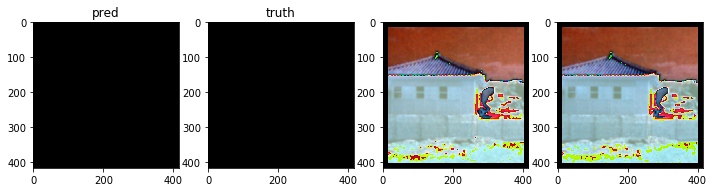

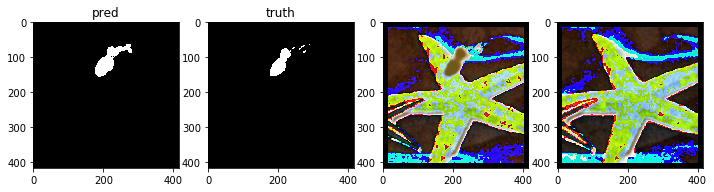

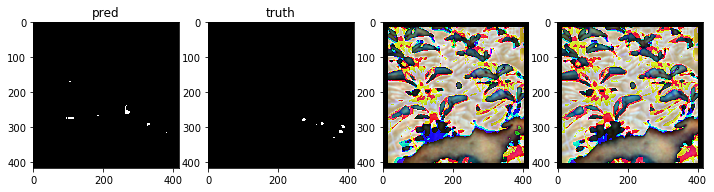

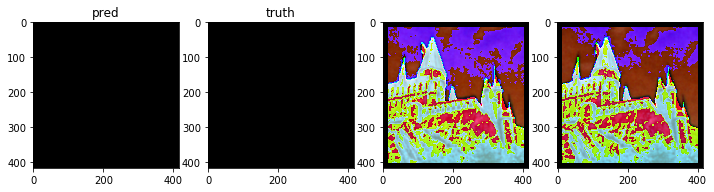

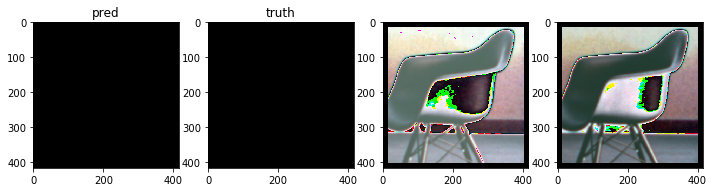

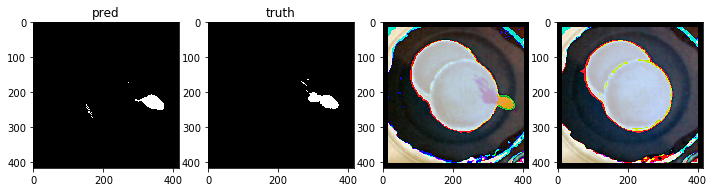

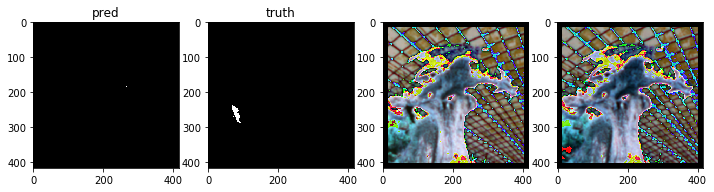

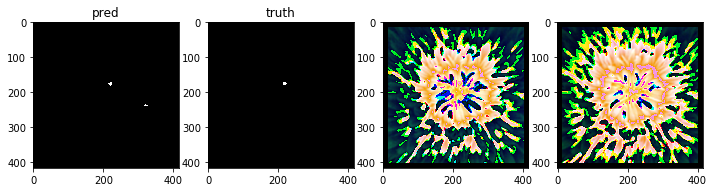

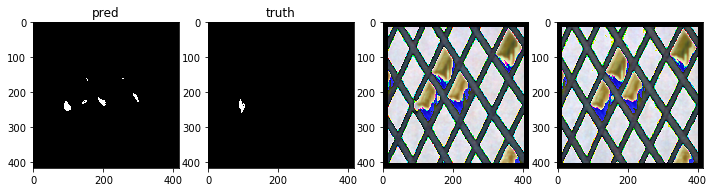

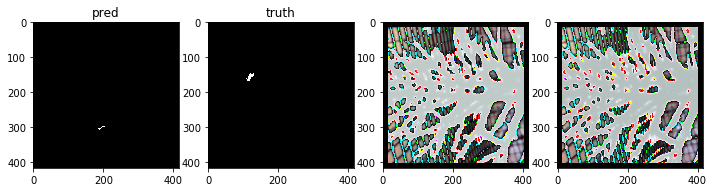

In [71]:
LL = range(3700,3710)
th = 0.5
print(PP.shape)
for NN in LL :
    plt.figure(figsize=(12,5))
    ppp = PP[NN].reshape(PP.shape[1:-1]).copy(); ppp[ppp>=th] = 1.0; ppp[ppp<th] = 0.0; 
    plt.subplot(1,4,1);  plt.imshow(ppp,'gray'); plt.title('pred')
    plt.subplot(1,4,2);  plt.imshow(YY[NN].reshape(YY.shape[1:-1]),'gray');  plt.title('truth')
    plt.subplot(1,4,3);  plt.imshow(X1[NN]);
    plt.subplot(1,4,4);  plt.imshow(X2[NN]);
    plt.show()

In [26]:
plt.close()

In [497]:
'''
print(K.get_value(f1scoreTF(YY[:4],PP[:4],th=None,printOK=True)))
print(K.get_value(f1scoreTF(YY[:4],PP[:4],th=0.1)))
print(K.get_value(f1scoreTF(YY[:4],PP[:4],th=0.5)))
print(K.get_value(f1scoreTF(YY[:4],PP[:4],th=0.8)))
print(K.get_value(f1scoreTF(YY[:4],PP[:4],th=0.9999,printOK=True)))
'''
tYY = K.variable(YY[:14])
tPP = K.variable(PP[:14])
print(K.get_value(K.mean(lossXf1(tYY,tPP),axis=(1,2))))
print(K.get_value(K.mean(keras.losses.binary_crossentropy(tYY,tPP),axis=(1,2))))

[ -3.73799419e+00  -6.86845660e-01  -3.87168646e-01  -5.70928633e-01
  -7.94541979e+00  -1.62381971e+00  -4.79906619e-01  -4.44859803e-01
  -9.23750496e+00   8.11254140e-03  -4.63137329e-01  -4.51516037e+01
   6.23761900e-02  -3.89903307e+00]
[ -3.11800957e+00   1.82744360e-03   2.38380581e-01   8.86177719e-02
  -7.32644749e+00  -9.92239833e-01   1.52948231e-01   1.75346300e-01
  -8.62314320e+00   5.75728536e-01   1.52001888e-01  -4.45593147e+01
   6.51660919e-01  -3.30966520e+00]


In [31]:
if 1 :
    
    filepath = '../Temp/V02-level-1-val_f1scoreTF=0.6886-(0.6856).hdf5'  # level 1
    filepath = '../Temp/V02-level-2-val_f1scoreTF=0.5335-(0.6606).hdf5'  # level 2
    filepath = '../Temp/V02-level-3-val_f1scoreTF=0.5343-(0.5744).hdf5'  # level 3
    
    K.clear_session()
    
    model10 = mergeXX((416,416,3))
    model10.load_weights(filepath, by_name=True) 
    model10.compile(loss=lossZf1, #'binary_crossentropy',
              optimizer='adam', #sgd, #"adam", #'rmsprop',
              metrics=['binary_accuracy',f1scoreTF]) 
    
if 1 :
    print(datetime.datetime.now())
    PP = model10.predict([X1,X2],batch_size=batch_size)
    print(datetime.datetime.now())    

2018-02-15 21:36:44.034606
2018-02-15 21:39:06.456198


In [66]:
def dataLoad(fileNN, fileX1, fileX2) :
    NN, X1, X2 = np.load(fileNN), np.load(fileX1), np.load(fileX2)
    return(NN,X1,X2)

In [67]:
def modelLoad (filepath) :
    
    K.clear_session()
    model10 = mergeXX((416,416,3))
    model10.load_weights(filepath, by_name=True) 
    model10.compile(loss=lossZf1, #'binary_crossentropy',
              optimizer='adam', #sgd, #"adam", #'rmsprop',
              metrics=['binary_accuracy',f1scoreTF]) 
    return(model10)

def modelPredict (model, X1, X2, batch_size=18) :
    PP = model10.predict([X1,X2],batch_size=batch_size)
    return(PP)

def modelLoadAndPredict (filepath, X1, X2, batch_size=18) :
    model10 = modelLoad(filepath)
    PP      = model10.predict([X1,X2],batch_size=batch_size)
    return(PP)

In [103]:
def saveResult(dirPath, PP, fileList, th=0.5) :
    
    for ii,fn in enumerate(fileList) :
        
        #if ii>5 : break;
        
        #print(ii,fn,dirPath,fn+'_mask.txt')
        pp = np.array(PP[ii]); pp[pp<=th]=0; pp[pp>=th]=1; pp=np.array(pp,dtype=np.int8)
        
        DIMENSION = 390
        out = open(os.path.join(dirPath,fn+'_mask.txt'),'w');
        for x in xrange(DIMENSION):
            for y in xrange(DIMENSION):
                out.write(str(int(pp[13+x, 13+y])))
            out.write('\n')
        out.close()        
        
        if ii%500==0 : print(datetime.datetime.now(), '\t', ii,'/',len(fileList), fn)
            
    return
        

In [98]:
def clearDirectory(dirPath) :
    import shutil
    shutil.rmtree(dirPath)
    return

In [104]:
# Build decision
# Train datas

print(datetime.datetime.now(), 'Begin')


dirForResult = '../Result/Temp'

filemodel = ['../Temp/V02-level-1-val_f1scoreTF=0.6886-(0.6856).hdf5',  # level 1
             '../Temp/V02-level-2-val_f1scoreTF=0.5335-(0.6606).hdf5',  # level 2 
             '../Temp/V02-level-3-val_f1scoreTF=0.5343-(0.5744).hdf5']  # level 3

ths = (0.45,0.3,0.3)

clearDirectory(dirForResult)
if not os.path.exists(dirForResult) : os.makedirs(dirForResult)

for ii in (0,1,2) :
    
    #if ii==1 : break
        
    print(datetime.datetime.now(), ii, 'Train')
    
    fileNN = os.path.join(dirForSave,'train-'+str(ii)+'-NN-101D01.npy')
    fileX1 = os.path.join(dirForSave,'train-'+str(ii)+'-X1-101D01.npy')
    fileX2 = os.path.join(dirForSave,'train-'+str(ii)+'-X2-101D01.npy')
    
    NN, X1, X2 = np.load(fileNN), np.load(fileX1), np.load(fileX2)
    PP     = modelLoadAndPredict(filemodel[ii], X1, X2)
    saveResult(dirForResult,PP,NN,ths[ii])
    
# Test/Dev datas

for ii in (0,1,2) :
    
    #if ii==1 : break
        
    print(datetime.datetime.now(), ii, 'Dev/Test')
        
    fileNN = os.path.join(dirForSave,'dev-'+str(ii)+'-NN-101D01.npy')
    fileX1 = os.path.join(dirForSave,'dev-'+str(ii)+'-X1-101D01.npy')
    fileX2 = os.path.join(dirForSave,'dev-'+str(ii)+'-X2-101D01.npy')
    
    NN, X1, X2 = np.load(fileNN), np.load(fileX1), np.load(fileX2)
    PP     = modelLoadAndPredict(filemodel[ii], X1, X2)
    saveResult(dirForResult,PP,NN,ths[ii])
    
print(datetime.datetime.now(), 'End')
    

2018-02-16 02:45:14.159820 Begin
2018-02-16 02:45:14.306012 0 Train
2018-02-16 02:45:46.982831 	 0 1014
2018-02-16 02:46:34.664324 	 500 577
2018-02-16 02:46:57.450501 1 Train
2018-02-16 02:48:47.817969 	 0 1003
2018-02-16 02:49:38.471846 	 500 4958
2018-02-16 02:50:25.925992 	 1000 3790
2018-02-16 02:51:11.857867 2 Train
2018-02-16 02:53:29.223843 	 0 1001
2018-02-16 02:54:18.071272 	 500 1253
2018-02-16 02:55:05.476980 	 1000 3818
2018-02-16 02:55:52.124184 	 1500 5485
2018-02-16 02:56:25.859638 0 Dev/Test
2018-02-16 02:56:39.472358 	 0 1033
2018-02-16 02:57:01.893265 1 Dev/Test
2018-02-16 02:57:44.601397 	 0 4211
2018-02-16 02:58:33.421449 	 500 4713
2018-02-16 02:58:34.256980 2 Dev/Test
2018-02-16 02:59:28.139780 	 0 1000
2018-02-16 03:00:16.266204 	 500 2970
2018-02-16 03:00:30.281702 End


In [108]:
3004/4+5980/4+7492/4+490/2+1020/2+1300/2

5524

In [119]:
# write in zip file
import zipfile
try:
    import zlib
    compression = zipfile.ZIP_DEFLATED
except:
    compression = zipfile.ZIP_STORED

modes = { zipfile.ZIP_DEFLATED: 'deflated',
          zipfile.ZIP_STORED:   'stored',
          }

print ('creating archive')
zf = zipfile.ZipFile('../Result/KM2018.zip', mode='w')
try:
    print ('adding with compression mode', modes[compression])
    for fn in os.listdir(dirForResult) :
        #zf.write('../Result/bobaUrban3D.txt', arcname='bobaUrban3D.txt', compress_type=compression)
        if fn.startswith('.') : continue
        zf.write(os.path.join('../Result/Temp',fn), arcname=fn, compress_type=compression)
finally:
    print ('closing')
    zf.close()
print(datetime.datetime.now())

creating archive
adding with compression mode deflated
closing
2018-02-16 04:24:36.909788


In [117]:
dirForResult2 = '../Result/Temp2'
for ii in range(1,6882+1) :
    if not os.path.exists(os.path.join(dirForResult,str(ii)+'_mask.txt')) :
        DIMENSION = 390
        out = open(os.path.join(dirForResult2,str(ii)+'_mask.txt'),'w');
        for x in xrange(DIMENSION):
            for y in xrange(DIMENSION):
                out.write('0')
            out.write('\n')
        out.close()        
        
    if ii%500==0 : print(datetime.datetime.now(), '\t', ii)

2018-02-16 04:20:08.568406 	 3500
2018-02-16 04:20:14.711774 	 4500


In [118]:
5524+1358

6882

In [97]:
K.clear_session()

In [32]:
#K.clear_session()
sstep = 150
th    = 0.8

res   = []

print(filepath)

for th in (0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9) :
    tRR = np.zeros(len(YY),dtype=np.float32)
    for ii in range(0,4100,sstep) :
        K.clear_session()
        tYY = K.variable(YY[ii:ii+sstep])
        #tPP = K.zeros(PP[ii:ii+sstep].shape) #K.variable(PP[ii:ii+sstep])
        tPP = K.variable(PP[ii:ii+sstep])
        tRR[ii:ii+sstep] = K.get_value(f1scoreTF(tYY,tPP,th=th))
        #print(th,'\t',ii,'\t',K.get_value(K.mean(f1scoreTF(tYY,tPP,th=th))))
        del tYY,tPP
    print(th,'\t',tRR.mean(),'\t',tRR[0:751].mean(),'\t',tRR[751:751+1495].mean(),'\t',tRR[751+1495:5000].mean())
    res.append((th,tRR))
    del tRR

../Temp/V02-level-3-val_f1scoreTF=0.5343-(0.5744).hdf5
0.3 	 0.58419 	 0.690148 	 0.52679 	 0.58752
0.4 	 0.574512 	 0.685194 	 0.518464 	 0.574869
0.5 	 0.562954 	 0.678447 	 0.506875 	 0.561408
0.6 	 0.550016 	 0.670798 	 0.496411 	 0.544374
0.7 	 0.534678 	 0.660861 	 0.484684 	 0.523988
0.8 	 0.512988 	 0.641193 	 0.471243 	 0.494903
0.9 	 0.476945 	 0.605792 	 0.448813 	 0.447737


In [33]:
res3 = res

In [44]:
res = np.array([[xx for _,xx in res1],[xx for _,xx in res2],[xx for _,xx in res3]])
res.shape
resZ= np.array([res[:,:,0:751].mean(axis=(2)),res[:,:,751:751+1495].mean(axis=(2)),res[:,:,751+1495:].mean(axis=(2))])
resZ.shape
resZ

array([[[ 0.70601404,  0.70750928,  0.70122015,  0.68732005,  0.66076815,
          0.61429679,  0.54274154],
        [ 0.68137407,  0.67925268,  0.67174083,  0.66424555,  0.65152645,
          0.63359588,  0.6018284 ],
        [ 0.69014794,  0.68519378,  0.67844695,  0.67079782,  0.66086078,
          0.64119285,  0.60579157]],

       [[ 0.39948612,  0.40018928,  0.39511365,  0.38774005,  0.38298243,
          0.382274  ,  0.3754313 ],
        [ 0.65529597,  0.64452708,  0.62821454,  0.60826319,  0.58446556,
          0.55561578,  0.51141679],
        [ 0.52678972,  0.51846391,  0.50687522,  0.49641082,  0.48468405,
          0.47124338,  0.44881293]],

       [[ 0.36642477,  0.36879611,  0.36070454,  0.35326034,  0.34285849,
          0.32835168,  0.31077576],
        [ 0.4617624 ,  0.44781733,  0.43527529,  0.42080134,  0.40481281,
          0.38740641,  0.36380115],
        [ 0.58752024,  0.57486904,  0.5614078 ,  0.54437363,  0.52398831,
          0.49490297,  0.44773728]]], dtyp

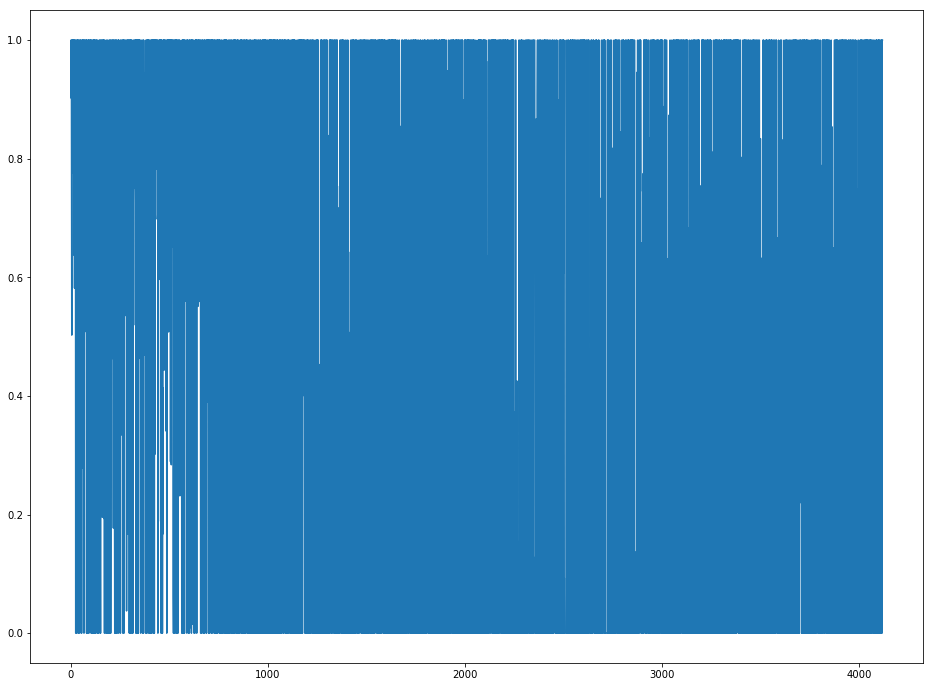

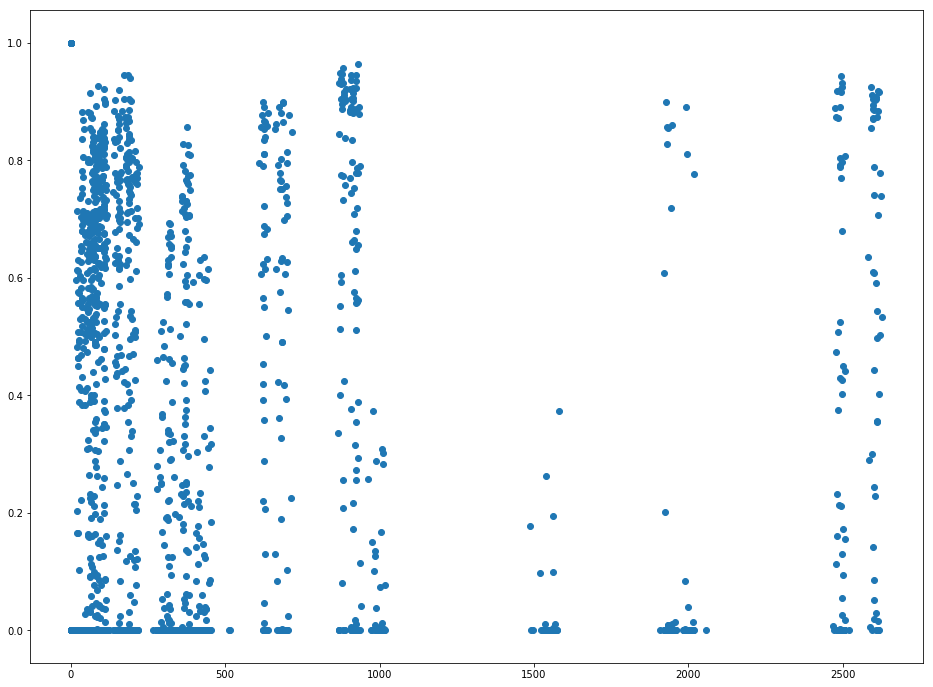

In [36]:
tRR.shape
plt.figure(figsize=(16,12))
plt.plot(tRR); plt.show()
tYY = YY.sum(axis=(1,2))
plt.figure(figsize=(16,12))
plt.scatter(tYY,tRR); plt.show()


In [128]:
416*416

173056

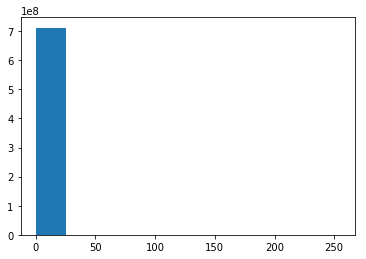

array([ 255.,  255.,  255., ...,  255.,  255.,  255.], dtype=float32)

In [143]:
#tYY.shape
#YY.max()
plt.hist(YY.ravel()); plt.show()
YY[YY>0]

In [174]:

#model10.lr.get_value()
K.get_value(model10.optimizer.lr)
K.set_value(model10.optimizer.lr, 0.001)
K.get_value(model10.optimizer.lr)


0.001

In [477]:
if 0 :
    for ll in model10.layers : 
        if (ll.name.startswith('boba1')) : 
            print(ll.name, ll.trainable)
            ll.trainable = True
if 1 :
    #model10.compile(loss='binary_crossentropy', #lossXf1, #'binary_crossentropy',
    model10.compile(loss=lossZf1, #'binary_crossentropy',
              optimizer='adam', #sgd, #"adam", #'rmsprop',
              metrics=['binary_accuracy',f1scoreTF]) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])


In [344]:
py[:,py[1]==0].shape
py[:,py[1]>0].shape

(2, 2737)

In [350]:
float(2737+1405)/(4119+1405)

0.7498189717595944

In [183]:
YY.shape

(4119, 416, 416, 1)

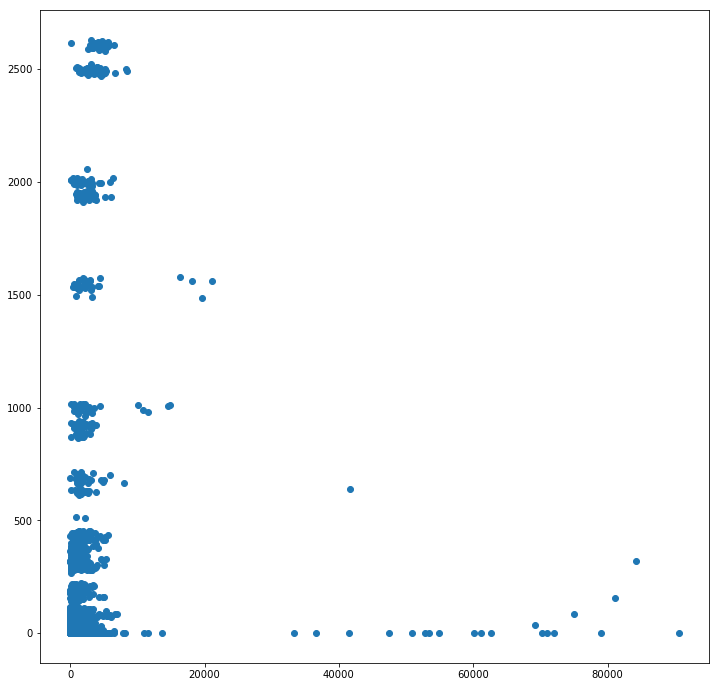

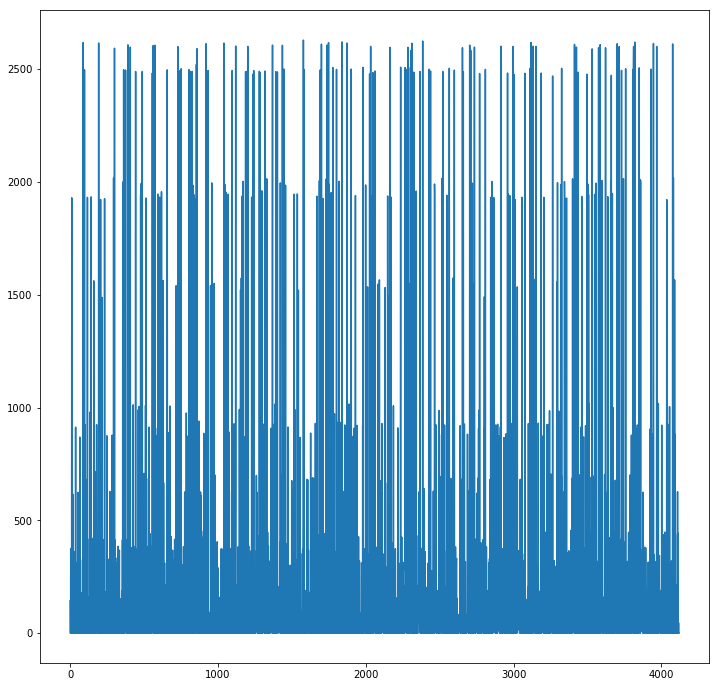

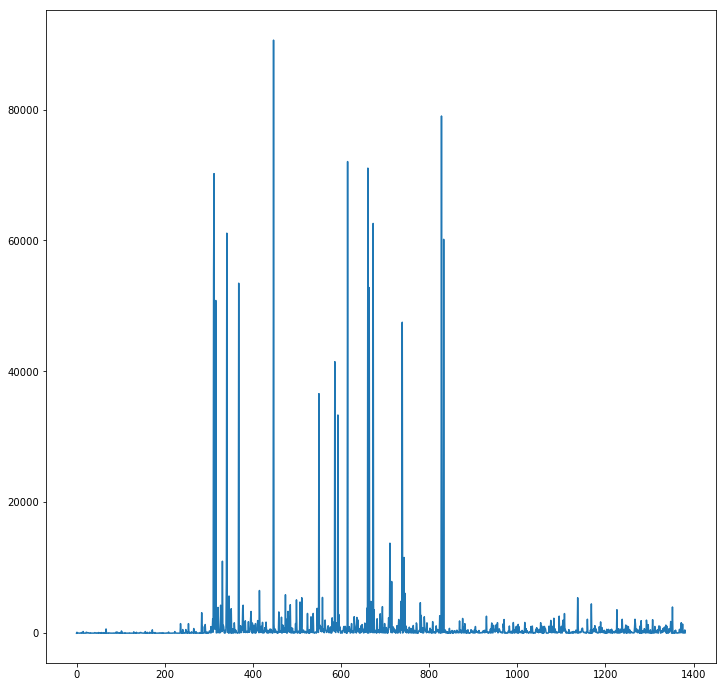

In [182]:
th = 0.5
pl,yl = [],[]
for ppp,yyy in zip(PP,YY) : 
    pl.append(len(ppp[ppp>th]))
    yl.append(len(yyy[yyy>th]))    
    
py = np.array([pl,yl])
plt.figure(figsize=(12,12))
plt.scatter(py[0],py[1]); plt.show()
plt.figure(figsize=(12,12))
plt.plot(py[1]); plt.show()

plt.figure(figsize=(12,12))
plt.plot(py[:,py[1]==0][0]); plt.show()


In [ ]:
    early_stopping = EarlyStopping(monitor='val_loss',     patience=6,min_delta=0.0001,verbose=1)
    reduce_lr1     = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.00000001,verbose=1)
    reduce_lr2     = ReduceLROnPlateau(monitor='loss',     factor=0.5,patience=2, min_lr=0.00000001,verbose=1)

    #filepath="../Temp/V2-UNET-val_"+metric+"={val_"+metric+":.4f}-full.hdf5"
    #filepath="../Temp/V2-UNET-val_"+metric+"={val_"+metric+":.4f}.hdf5"
    #filepath="../Temp/V2-UNETx5-val_"+metric+"={val_"+metric+":.4f}.hdf5"
    filepath="../Temp/V2-UNETx5-val_"+metric+"={val_"+metric+":.4f}-full.hdf5"
    
    checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
    checkpoint2 = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')



In [23]:
import tensorflow as tf

#--------------------------------------------------------------------------
def F1ScoreCC (truth, pred_, th=None, printOK=False) : # classic realization
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
        
    tp     = K.sum(truth*pred,           axis=(1,2,3))
    fp     = K.sum(K.abs(truth-1.0)*pred,axis=(1,2,3))
    fn     = K.sum(truth*K.abs(pred-1.0),axis=(1,2,3))
    
    #if (tp+fp)>0.0 :precision = tp/(tp+fp)
    #if (fp+fn)>0.0 : recall    = tp/(fp+fn)
    
    tpfp   = tp+fp
    tpfn   = tp+fn

    kUp       = tf.to_float(K.not_equal(0.0,tpfp))
    kDown     = tf.to_float(K.equal    (0.0,tpfp))
    precision = (tp*kUp)/(K.maximum((tp+fp),kDown))

    kUp       = tf.to_float(K.not_equal(0.0,tpfn))
    kDown     = tf.to_float(K.equal    (0.0,tpfn))
    recall    = (tp*kUp)/(K.maximum((tp+fn),kDown))

    prre      = precision+recall

    kUp       = tf.to_float(K.not_equal(0.0,prre))
    kDown     = tf.to_float(K.equal    (0.0,prre))
    fscore = (2.0*precision*recall*kUp)/K.maximum((precision+recall),kDown)
        
    ##dice = K.mean((2.0*x+0.001)/(g+s+0.001),axis=-1)

    
    if printOK : print(K.eval(tp),K.eval(fp),K.eval(fn),K.eval(precision),K.eval(recall),K.eval(fscore))
        
    return(K.clip(fscore, 0.0, 1.0))


def F1ScorePP (truth, pred_, th=None, th1=0.55, th1sum=0.1, kernel=31) :
    
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
        
    one15  = K.ones((kernel,kernel,1,1))
    one15s = kernel*kernel

    def convHV(truth,pred,axis=-1) :
        #tp     = K.sum(truth*pred,axis=(1,2,3))
        #fp     = K.sum(K.abs(truth-1.0)*pred)
        #fn     = K.sum(K.abs(truth-1.0)*K.abs(pred-1.0))
        
        tp     = K.conv2d(truth*pred,                       one15,strides=(1,1),padding='same',dilation_rate=None)
        fp     = K.conv2d(K.abs(truth-1.0)*pred,            one15,strides=(1,1),padding='same',dilation_rate=None)
        fn     = K.conv2d(truth*K.abs(pred-1.0),            one15,strides=(1,1),padding='same',dilation_rate=None)
        
        #print(K.eval(tp),K.eval(fp),K.eval(fn))
        
        tpfp   = tp+fp
        tpfn   = tp+fn
        
        kUp       = tf.to_float(K.not_equal(0.0,tpfp))
        kDown     = tf.to_float(K.equal    (0.0,tpfp))
        precision = (tp*kUp)/(K.maximum((tp+fp),kDown))
        
        kUp       = tf.to_float(K.not_equal(0.0,tpfn))
        kDown     = tf.to_float(K.equal    (0.0,tpfn))
        recall    = (tp*kUp)/(K.maximum((tp+fn),kDown))
        
        prre      = precision+recall

        kUp       = tf.to_float(K.not_equal(0.0,prre))
        kDown     = tf.to_float(K.equal    (0.0,prre))
        fscore = (2.0*precision*recall*kUp)/K.maximum((precision+recall),kDown)

        return(K.clip(fscore, 0.0, 1.0))
        
    F1Score = convHV(truth,pred)
    
    F1Score = K.mean(F1Score,axis=-1) #dice/(15.0*15.0)
    
    # ????dd        = K.clip(tf.to_float(K.greater(dice,th1))+th1sum,th1sum,1.0)
    # ????dice      = dice*dd
    
    return(K.clip(F1Score, 0.0, 1.0))

def diceCC (truth, pred_, th=None) : # classic realization = inter/union
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
    g, s = K.sum(truth,axis=(1,2,3)), K.sum(pred,axis=(1,2,3))
    x    = K.sum(truth*pred,axis=(1,2,3))
    dice = K.mean((2.0*x+0.001)/(g+s+0.001),axis=-1)
    return(K.clip(dice, 0.0, 1.0))

def dicePP_old (truth, pred, th=None, th1=0.45, th1sum=0.1) :
    
    def diceHV(truth,pred,axis=-1) :
        g, s, x  = K.sum(truth,axis=axis), K.sum(pred,axis=axis), K.sum(truth*pred,axis=axis)
        diceMean = K.mean((2.0*x+1.0)/(g+s+1.0),axis=-1)
        dd       = K.clip(tf.to_float(K.greater(diceMean,th1))+th1sum,th1sum,1.0)
        diceMean = dd*diceMean
        return (diceMean)
        
    diceMean1 = diceHV(truth,pred,axis=(2,3))
    diceMean2 = diceHV(truth,pred,axis=(1,3))
    
    dice      = (diceMean1+diceMean2)/2.0
    dd        = K.clip(tf.to_float(K.greater(dice,th1)),th1sum,1.0)
    dice      = dice*dd
    
    return(K.clip(dice, 0.0, 1.0))

def dicePP (truth, pred, th=None, th1=0.55, th1sum=0.1) :
    
    one15  = K.ones((15,15,1,1))
    one15s = 15.0*15.0

    def diceHV(truth,pred,axis=-1) :
        g  = K.conv2d(truth,one15,strides=(1,1),padding='same',dilation_rate=None) #dilation_rate
        s  = K.conv2d(pred ,one15,strides=(1,1),padding='same',dilation_rate=None)
        x  = K.conv2d(truth*pred,one15,strides=(1,1),padding='same',dilation_rate=None)
        diceMean = (2.0*x+0.001)/(g+s+0.001) # /one15s
        dd       = K.clip(tf.to_float(K.greater(diceMean,th1))+th1sum,th1sum,1.0)
        diceMean = diceMean*dd
        return (diceMean)
        
    diceMean1 = diceHV(truth,pred)
    
    dice      = K.mean(diceMean1,axis=-1) #dice/(15.0*15.0)
    
    # ????dd        = K.clip(tf.to_float(K.greater(dice,th1))+th1sum,th1sum,1.0)
    # ????dice      = dice*dd
    
    return(K.clip(dice, 0.0, 1.0))

def dicePP01 (truth, pred, th=0.5) : return(dicePP(truth,pred,th=th))

def dice01 (truth, pred_, th=0.5) :
    pred   = tf.to_float(K.greater(pred_,th))
    return (dicePP(truth,pred))
    
def dicePP01 (truth, pred, th=0.5) : return(dicePP(truth,pred,th=th))

def dice (truth, pred, th=0.5) :
    return(diceCC(truth,pred,th=th))

def f1scoreTF (truth, pred, th=0.5) :
    return(F1ScoreCC(truth,pred,th=th))

def lossXf1 (truth,pred) :
    return(losses.binary_crossentropy(truth,pred) - K.log(F1ScorePP(truth,pred)))

def lossYf1 (truth,pred) :
    #return( - K.log(F1ScoreCC(truth,pred) ))
    return( 1.0 - F1ScorePP(truth,pred))

def lossXdice (truth,pred) :
    return(losses.binary_crossentropy(truth,pred) - K.log(dicePP01(truth,pred)))

def lossYdice (truth,pred) :
    return( - K.log(dicePP(truth,pred) ))

In [ ]:
"https://drive.google.com/uc?export=download&id=" + id

In [ ]:
https://drive.google.com/open?id=14Z68n4NLI83VjW0sgT59xhudjqkD5R4o

In [158]:
def getURL() :
    id = '14Z68n4NLI83VjW0sgT59xhudjqkD5R4o'
    #return('http://www.lenta.ru')
    #return("https://drive.google.com/uc?dl=0?export=download&id=" + id)
    return('https://drive.google.com/open?id=14Z68n4NLI83VjW0sgT59xhudjqkD5R4o')
    #return('https://drive.google.com/file/d/14Z68n4NLI83VjW0sgT59xhudjqkD5R4o/view?usp=sharing')

In [159]:
getURL()

'https://drive.google.com/uc?dl=0?export=download&id=14Z68n4NLI83VjW0sgT59xhudjqkD5R4o'